In [1]:
from pyALT import *
import pyALT.io as io
from scipy.stats import kendalltau
from scipy.stats import pearsonr
import pickle as pk
from PIL import Image
from matplotlib import pyplot as plt
from collections import namedtuple

In [3]:
mask = load_mask('Animal A - M022411')

In [4]:
G = io.load('meso_cortex.pk')
L = ALT(G)
thresholds = {'VISp':4,'AUDp':1,'GU':2.5,'SSp-ul':2.5,'SSp-tr':2.5,
              'SSp-m':4,'SSp-bfd':4,'SSp-ll':1.5,'SSp-n':0.98,'MOB':0.46}
srcs = ['SSp-n','AUDp','VISp','GU','SSp-ul','SSp-tr','SSp-m','SSp-bfd','SSp-ll','MOB']
for src in srcs:
    L.add_source(src)
    L.set_theta(src,0.98)
L.set_theta('MOB',0.46)
L.run()
L.form_paths()
pc = L.path_centrality()
core = L.core()
core_nodes = [xx[0] for xx in core]
with open('info.pk','rb') as f:
    tx = pk.load(f)

In [5]:
import copy

38


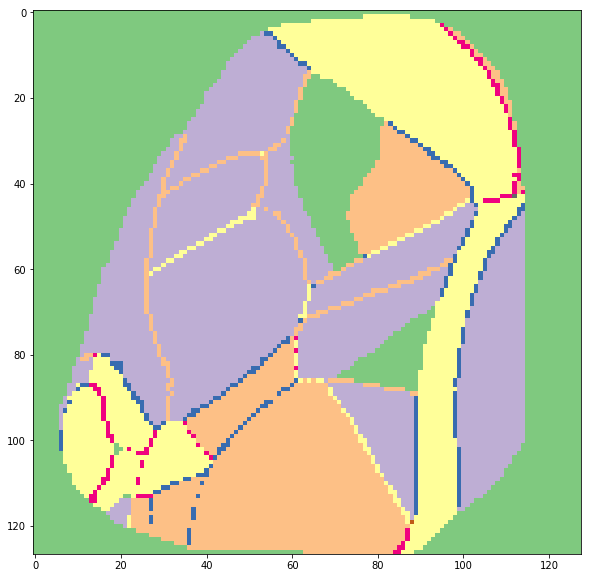

In [6]:
m = copy.deepcopy(mask)
for i,k in enumerate(tx['mapped_rois']):
    r = np.random.randint(2,15)
    m +=  (r)*np.array(tx['mapped_rois'][k],dtype='int8')
m[mask==0] = -1
print(np.max(m))
fig= plt.figure(figsize=(10,10))
plt.imshow(m,cmap='Accent')

In [7]:
with open('a1-visual-4.pk','rb') as f:
    visp = pk.load(f)
m,n = mask.shape
vsd = np.zeros((m,n))
s = set([])
for i in range(m):
    for j in range(n):
        try:
            x = visp[(i,j)].peak_time
            vsd[i][j] = x
            s.add(x)
        except KeyError:
            pass

In [8]:
res = {}
sensor = 'VISp'
res[sensor] = defaultdict(list)
for w in tx['mapped_rois']:
    if w in tx['ex']:continue
    roi = tx['mapped_rois'][w]
    for i in range(m):
        for j in range(n):
            if roi[i][j]<1:continue
            tmp = vsd[i,j]
            if tmp>=31:
                res[sensor][w] += [tmp]

In [9]:
def dist_break(x):
    out = []
    N = np.sum([xx[1] for xx in x])
    out.append((x[0][0],x[0][1]*100/N))
    x = sorted(x,key=lambda x:x[0])
    q = 0
    a5 = int(N*.05)
    a50 = int(N*.5)
    a5_set = False
    a50_set = False
    for w in x:
        q+=w[1]
        if q>=a5 and not a5_set:
            out.append(w[0])
            a5_set = True
        if q>=a50 and not a50_set:
            out.append(w[0])
            a50_set = True
        if a5_set and a50_set:break
    return out
Majid = namedtuple('Majid','roi init med mode freq')
S = {}
print('ROI, 5-percentile,Median, Mode, Mode Freq.')
for w in res[sensor]:
    cur = res[sensor][w]
    c = Counter(cur)
    tmp = sorted([(x,c[x]) for x in c],reverse=True,key = lambda x:x[1])
    y = dist_break(tmp)
    st = f'{w},{int(y[1])},{int(y[2])},{int(y[0][0])},{int(y[0][1])}'
    S[w] = Majid(roi=w,init=y[1],med=y[2],mode=y[0][0],freq =y[0][1])

ROI, 5-percentile,Median, Mode, Mode Freq.


In [10]:
Sp = {}
for k in S:
    Sp[k] = S[k].init

In [11]:
adag = L('VISp')
Z = {}
tmp = [xx.mode for xx in S.values()]
mm = min(tmp)
mx = max(tmp)
for w in S:
    roi = S[w].roi
    Z[roi] = adag.node[roi]['activation_time']
tmp = [xx for xx in Z.values()]
zm = min(tmp)
zx = max(tmp)
ZZ = {}
for w in S:
    roi = S[w].roi
    ZZ[roi] = mm+(mx-mm)*adag.node[roi]['activation_time']/zx
    ZZ[roi] = int(round(ZZ[roi]))

In [12]:
def plot_activation(acts1, acts2, acts3, rois,mask):
    m,n = mask.shape
    pic1 = np.zeros((m,n,3),dtype=np.uint8)
    pic1[:,:,2] = 255
    pic2 = np.zeros((m,n,3),dtype=np.uint8)
    pic2[:,:,2] = 255
    pic3 = np.zeros((m,n,3),dtype=np.uint8)
    pic3[:,:,2] = 255
    s = sorted(acts1.values())
    m0 = s[0]
    m1 = s[-1]
    s = sorted(acts2.values())
    n0 = s[0]
    n1 = s[-1]
    s = sorted(acts3.values())
    p0 = s[0]
    p1 = s[-1]
    for roi in acts1:
        _level = (acts1[roi]-m0)/(m1-m0)
        level1 = int(_level*255)
        _level = (acts2[roi]-n0)/(n1-n0)
        level2 = int(_level*255)
        _level = (acts3[roi]-p0)/(p1-p0)
        level3 = int(_level*255)
        cur = rois[roi]
        pic1[cur==1,0] = level1
        pic1[cur==1,1] = level1
        pic1[cur==1,2] = level1
        pic2[cur==1,0] = level2
        pic2[cur==1,1] = level2
        pic2[cur==1,2] = level2
        pic3[cur==1,0] = level3
        pic3[cur==1,1] = level3
        pic3[cur==1,2] = level3
    return (pic1,pic2,pic3)

In [13]:
pic1, pic2, pic3 = plot_activation(Sp,Z,ZZ,tx['mapped_rois'],mask)

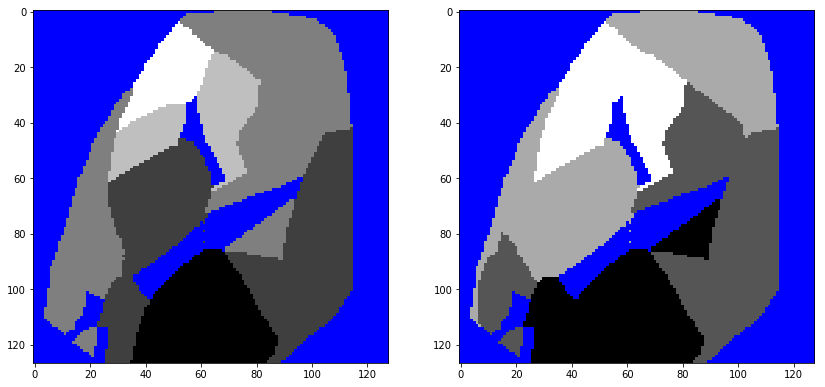

In [15]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,8))
ax[0].imshow(pic1)
ax[1].imshow(pic3)
# ax[2].imshow(pic2)

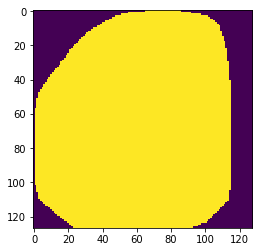

In [96]:
plt.imshow(mask)

In [93]:
pic1

array([[[  0.,   0., 255.],
        [  0.,   0., 255.],
        [  0.,   0., 255.],
        ...,
        [  0.,   0., 255.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[  0.,   0., 255.],
        [  0.,   0., 255.],
        [  0.,   0., 255.],
        ...,
        [  0.,   0., 255.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[  0.,   0., 255.],
        [  0.,   0., 255.],
        [  0.,   0., 255.],
        ...,
        [  0.,   0., 255.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       ...,

       [[  0.,   0., 255.],
        [  0.,   0., 255.],
        [  0.,   0., 255.],
        ...,
        [  0.,   0., 255.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[  0.,   0., 255.],
        [  0.,   0., 255.],
        [  0.,   0., 255.],
        ...,
        [  0.,   0., 255.],
        [  0.,   0., 255.],
        [  0.,   0., 255.]],

       [[  0.,   0., 255.],
        [  0.,   0., 255.],
        [  0.,  

In [46]:
t[np.ones((3,3))==1,1] = 1

In [47]:
t

array([[[  0.,   1., 255.],
        [  0.,   1., 255.],
        [  0.,   1., 255.]],

       [[  0.,   1., 255.],
        [  0.,   1., 255.],
        [  0.,   1., 255.]],

       [[  0.,   1., 255.],
        [  0.,   1., 255.],
        [  0.,   1., 255.]]])